In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import ssl
import os

def load_img(path, normalize: bool = False):
    ext = os.path.splitext(path)[1].lower()
    arr = np.load(path).astype(np.float32)
    if normalize:
        arr = arr - arr.min()
        arr = arr / arr.max() * 255
    arr = arr.clip(0,255).astype(np.uint8)
    return arr

# **Finetune**

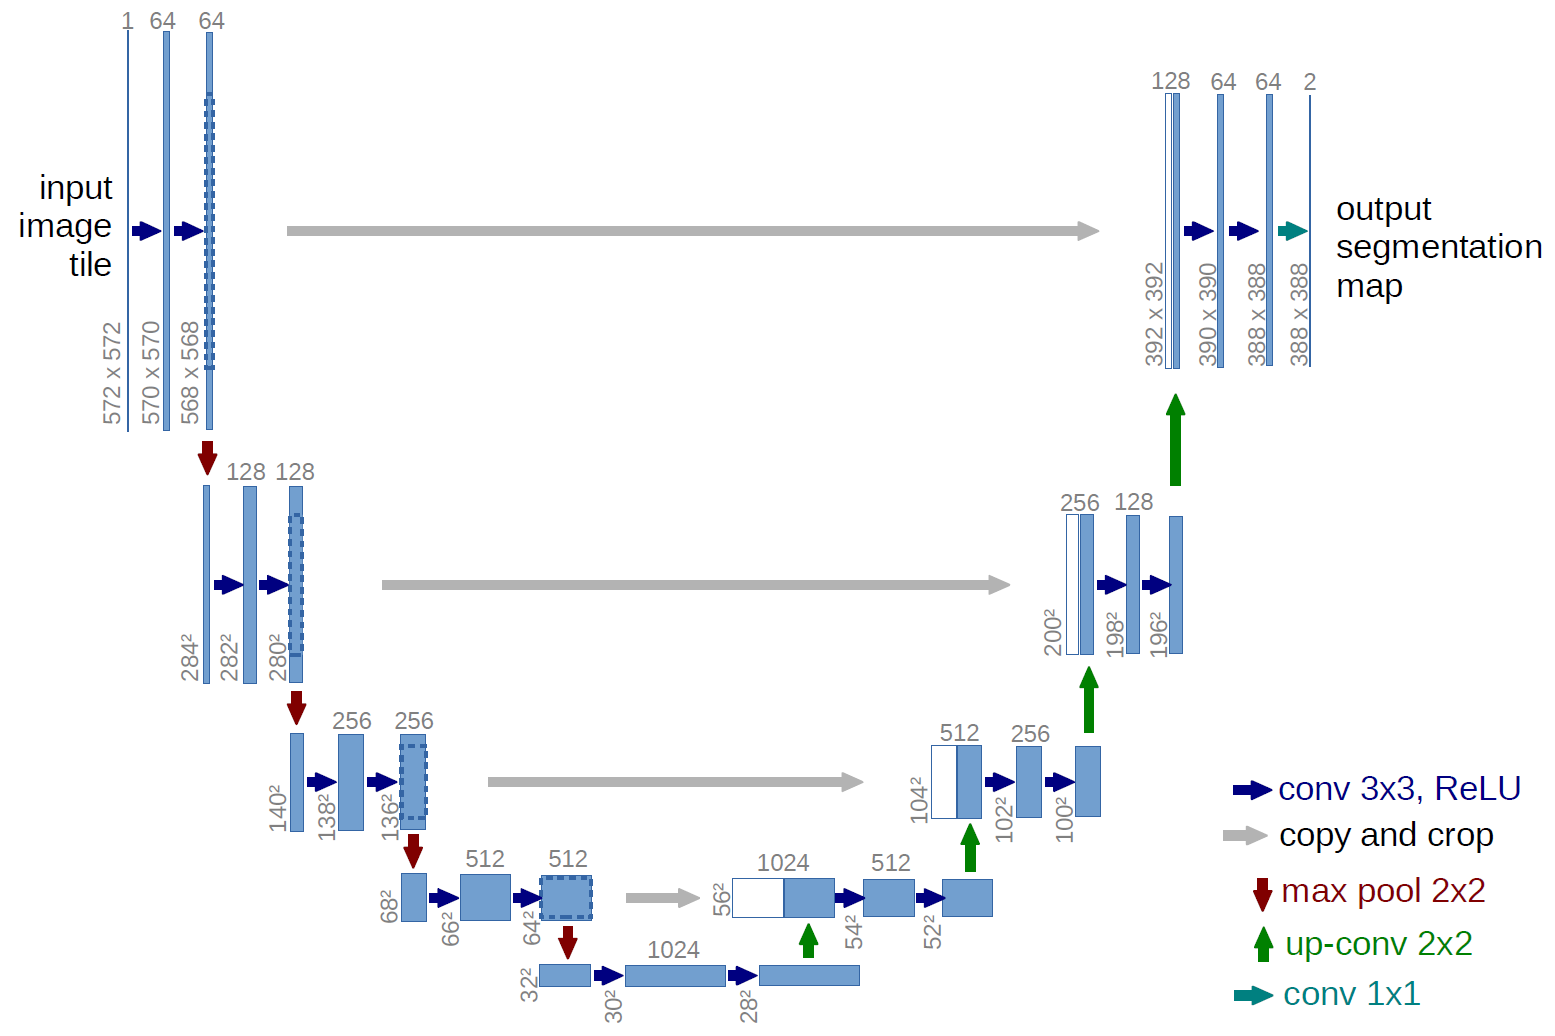

In [ ]:
import torch
import torch.nn as nn
class ToyUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
           nn.Conv2d(8, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        return x_dec

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ToyUNet().to(device)

# Freeze encoder weights (parameters will not be updated during training)
for param in model.encoder.parameters():
    param.requires_grad = False

batch_size, channels, height, width = 4, 1, 16, 16
inputs = torch.randn(batch_size, channels, height, width, device=device)
targets = torch.randn(batch_size, channels, height, width, device=device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)

model.train()
num_epochs = 3
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {loss.item():.4f}")


Epoch 1/3, loss: 1.0565
Epoch 2/3, loss: 1.0549
Epoch 3/3, loss: 1.0537


# Fourier Domain Adaptation

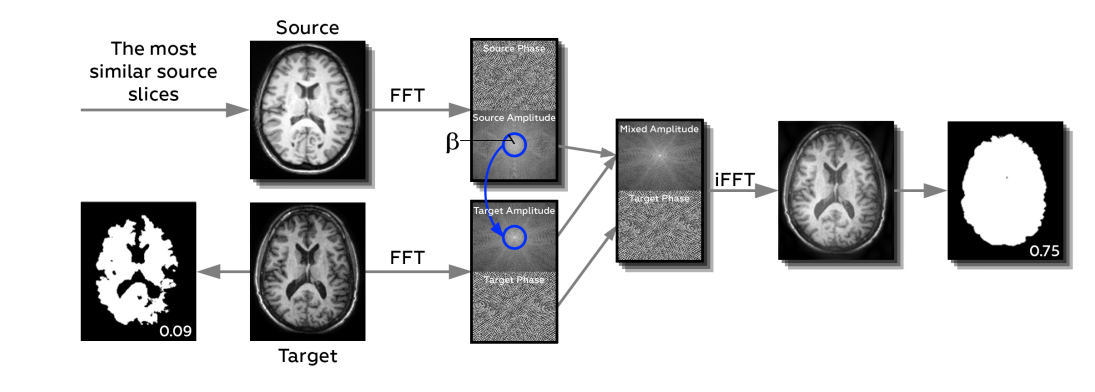

(np.float64(-0.5), np.float64(217.5), np.float64(181.5), np.float64(-0.5))

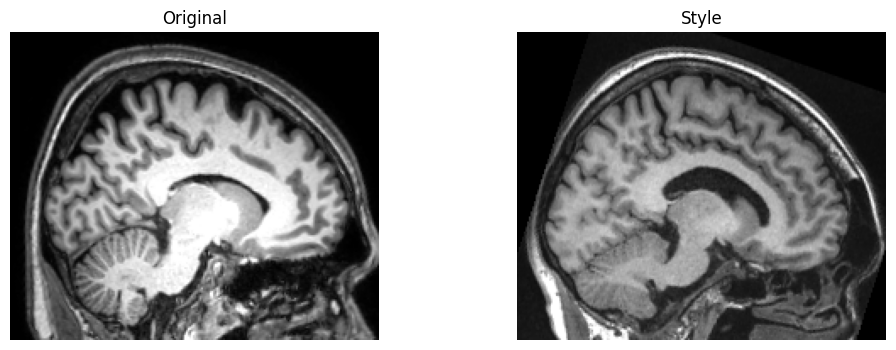

In [ ]:
img_st = load_img('CC0060_philips_3_29_M_1.npy',  normalize=True)
img_orig = load_img('CC0280_ge_15_57_F_1.npy', normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
im0 = ax[0].imshow(img_st, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

im1 = ax[1].imshow(img_orig, cmap='gray')
ax[1].set_title('Style')
ax[1].axis('off')

In [ ]:
import numpy as np
from skimage.transform import resize


class FDA:
    def __init__(self, is_low=True, radius=0.1):
        """
        :param is_low: Whether to use fftshift (shift low frequencies to center)
        :param radius: Radius for low-frequency mask as a fraction of image size (e.g., 0.1 = 10%)
        """
        self.is_low = is_low
        self.radius = radius

    def _create_circular_mask(self, h, w, center=None, radius=None):
        if center is None:
            center = (int(w / 2), int(h / 2))
        if radius is None:
            radius = min(center[0], center[1], w - center[0], h - center[1])

        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
        mask = dist_from_center < radius
        return mask

    def _image_change(self, image, style, beta=0.1):
        # Compute FFT
        f_image = np.fft.fft2(image)
        f_style = np.fft.fft2(style)

        # Optional shift to center
        if self.is_low:
            f_image = np.fft.fftshift(f_image)
            f_style = np.fft.fftshift(f_style)

        # Separate amplitude and phase
        amp_image, phase_image = np.abs(f_image), np.angle(f_image)
        amp_style = np.abs(f_style)

        # Create low-frequency mask
        h, w = image.shape
        mask_radius = min(h, w) * 0.5 * self.radius * beta
        mask = self._create_circular_mask(h, w, radius=mask_radius)

        # Replace amplitudes in low-frequency region
        amp_image[mask] = amp_style[mask]

        # Reconstruct FFT with mixed amplitude and original phase
        f_combined = amp_image * np.exp(1j * phase_image)

        if self.is_low:
            f_combined = np.fft.ifftshift(f_combined)

        # Inverse FFT to get result
        result = np.abs(np.fft.ifft2(f_combined))
        return result

    def predict(self, content_img, style_img, beta=0.1):
        """
        :param content_img: 2D numpy array (H, W)
        :param style_img: 2D numpy array (H, W)
        :return: image with FDA applied
        """
        # style_resized = resize(style_img, content_img.shape, anti_aliasing=True)
        return self._image_change(content_img, style_img, beta)


In [ ]:
fda = FDA(radius=1.0)

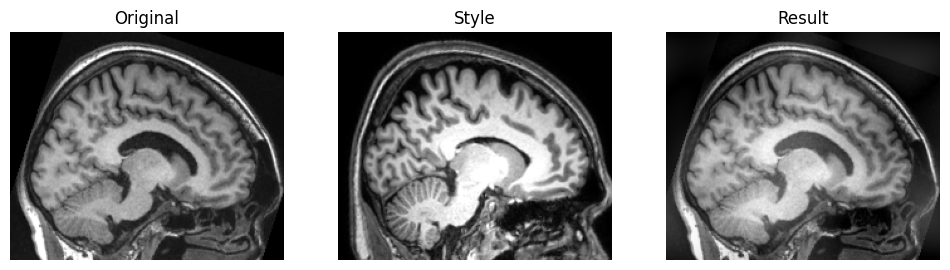

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

img_st = np.rot90(load_img('CC0060_philips_3_29_M.npy', normalize=True)[100, ...])
img_orig = np.rot90(load_img('CC0280_ge_15_57_F.npy', normalize=True)[100, ...])


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].imshow(img_orig, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

im1 = ax[1].imshow(img_st, cmap='gray')
ax[1].set_title('Style')
ax[1].axis('off')

translated = fda.predict(img_orig, img_st, beta=0.04)
im2 = ax[2].imshow(translated, cmap='gray')
ax[2].set_title('Result')
ax[2].axis('off')

plt.show()



#StyleTransfer example

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np

from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class VGG(nn.Module):

    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):

        outs = []
        for name, module in self.features._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                outs.append(x)
        return outs


def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def recover_image(tensor):
    image = tensor.detach().cpu().numpy()
    # np.array(cnn_normalization_mean).reshape((1, 3, 1, 1))
    # image = image * np.array(cnn_normalization_std).reshape((1, 3, 1, 1)) + \
    return (image.transpose(0, 2, 3, 1) * 255.).clip(0, 255).astype(np.uint8)[0]


def recover_tensor(tensor):
    m = torch.tensor(cnn_normalization_mean).view(1, 3, 1, 1).to(tensor.device)
    s = torch.tensor(cnn_normalization_std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * s + m
    return tensor.clamp(0, 1)


def preprocess_image(image, target_width=256):
    if target_width:
        t = transforms.Compose([
            transforms.Resize(target_width),
            transforms.CenterCrop(target_width),
            transforms.ToTensor(),
        ])
    else:
        t = transforms.Compose([
            transforms.ToTensor(),
        ])
    return t(image).unsqueeze(0)


def read_image(image, target_width):
    return preprocess_image(Image.fromarray((image * 255).astype(np.uint8)).convert('RGB'), target_width)


def get_resize_values(data_don, data_st, padding_value=(256, 256)):
    if data_don.n_dim == 2:
        data_x, data_y = padding_value - np.array(data_don.shape)
        style_x, style_y = padding_value - np.array(data_st.shape)
    elif data_don.n_dim == 3:
        data_x, data_y, _ = padding_value - np.array(data_don.shape)
        style_x, style_y, _ = padding_value - np.array(data_st.shape)
    else:
        raise ValueError('Amount of dims must be 2 or 3')

    get_offset = lambda x: (x // 2, x // 2 + 1) if x % 2 else (x // 2, x // 2)

    offsetx1_don, offsetx2_don = get_offset(data_x)
    offsety1_don, offsety2_don = get_offset(data_y)

    offsetx1_st, offsetx2_st = get_offset(style_x)
    offsety1_st, offsety2_st = get_offset(style_y)

    return ((offsetx1_don, offsetx2_don), (offsety1_don, offsety2_don)), \
           ((offsetx1_st, offsetx2_st), (offsety1_st, offsety2_st))


def predict_vgg(image_array, style_array, resize_flag=False, progress_bar=None, itt_numb=50,
                is_one_slice=False, padding_value=256):

    if resize_flag:
        offset_don, offset_st = get_resize_values(image_array, style_array, padding_value)

    if is_one_slice:
        image_array = np.expand_dims(image_array, axis=2)
        style_array = np.expand_dims(style_array, axis=2)

    result_list = np.zeros_like(image_array)
    target_width = padding_value if resize_flag else None


    vgg16 = models.vgg16(pretrained=True)
    vgg16 = VGG(vgg16.features[:23]).to(device).eval()
    vgg16 = vgg16.to(device)

    for pos, (content, style) in enumerate(tqdm(zip(np.rollaxis(image_array, 2), np.rollaxis(style_array, 2)))):
        # print(pos)
        if resize_flag:
            style = np.pad(style, offset_st, 'constant')
        style_img = read_image(style, target_width)
        style_img = style_img.to(device)



        content_img = read_image(content, target_width)
        content_img = content_img.to(device)


        style_features = vgg16(style_img)
        content_features = vgg16(content_img)

        style_grams = [gram_matrix(x) for x in style_features]

        input_img = content_img.clone()
        optimizer = optim.LBFGS([input_img.requires_grad_()])
        style_weight = 1e6
        content_weight = 1

        run = [0]
        while run[0] <= itt_numb:
            def f():
                optimizer.zero_grad()
                features = vgg16(input_img)

                content_loss = F.mse_loss(features[2], content_features[2]) * content_weight
                style_loss = 0
                grams = [gram_matrix(x) for x in features]
                for a, b in zip(grams, style_grams):
                    style_loss += F.mse_loss(a, b) * style_weight

                loss = style_loss + content_loss

                run[0] += 1

                loss.backward()
                return loss

            optimizer.step(f)


        input_img = input_img.detach().cpu().numpy()
        input_img = input_img[0, 0, ...]
        if resize_flag:
            (x1, x2), (y1, y2) = offset_don
            input_img = input_img[x1: 256 - x2, y1: 256 - y2]
        #print(input_img)
        result_list[..., pos] = input_img
        #print(result_list.shape)
    return result_list


In [ ]:
img_orig.max()

np.uint8(255)

In [ ]:
img_orig = load_img('CC0280_ge_15_57_F_1.npy',normalize=True)
img_orig = img_orig/img_orig.max()

img_st = load_img('CC0060_philips_3_29_M_1.npy',normalize=True)
img_st = img_st / img_st.max()

In [ ]:
vgg_model_results = predict_vgg(img_orig, img_st, is_one_slice=True, itt_numb=200)

1it [00:04,  4.68s/it]


In [ ]:
img_orig.max()

np.float64(1.0)

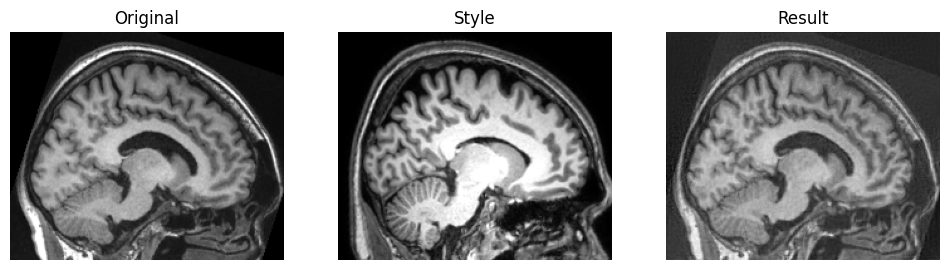

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].imshow(img_orig, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

im1 = ax[1].imshow(img_st, cmap='gray')
ax[1].set_title('Style')
ax[1].axis('off')

im2 = ax[2].imshow(vgg_model_results, cmap='gray')
ax[2].set_title('Result')
ax[2].axis('off')

plt.show()

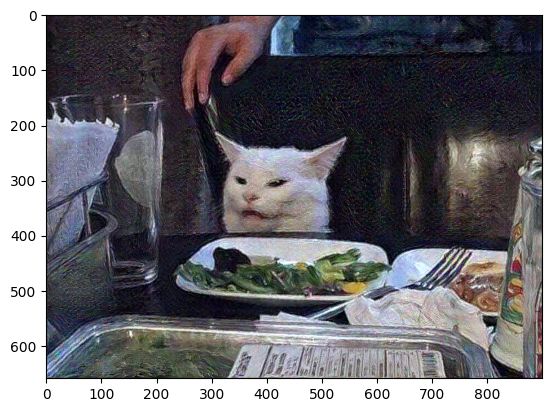

In [ ]:
plt.imshow(vgg_example, cmap='gray')